# CMA/ES PER SUBJECT - 3 try: LL92

3/3

Checking if LL92 gives some amount of random mixture proportion or not

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import os
import io
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
from IPython.utils import io

from experimentlauncher import ExperimentLauncher
from dataio import DataIO
import plots_experimental_data
import em_circularmixture_parametrickappa

import progress

# import matplotlib.animation as plt_anim
from mpl_toolkits.mplot3d import Axes3D

import glob
import re
import inspect
import imp

import utils
# import submitpbs
import load_experimental_data

from plots_fitexperiment_papertheo import PlotsFitExperimentAllTPaperTheo

oldstdout = None

## Reload data

In [4]:
%cd /nfs/data3/lmatthey/visual_working_mem/fitexperiment_subject_cmaes_08_2016/3try/

metric = 'dist_nll92'
folder_pattern = "cmaes_subjects_bays09_ll92_3try_Mratiosigmaxsigmabaselinelapserate_subject*rep5_090118"
re_subject = re.compile(".*subject([0-9]*)rep")

df_all_fits = None

for filename in glob.glob("./%s/outputs/cmaes_alliter_tracking*.npy" % folder_pattern):
    found = re_subject.match(filename)
    subject = int(found.group(1))
    print "Reloading data of Subject %d" % subject
    
    curr_cmaes_trace = np.load(filename).item()

    candidates_parameters = np.array(curr_cmaes_trace['candidates'])
    fitness = np.array(curr_cmaes_trace['fitness'])
    parameter_names_sorted = curr_cmaes_trace['parameter_names_sorted']
    
    df_fits_subject = pd.DataFrame.from_items([('step', np.arange(fitness.size)), 
                                               ('experiment_subject', subject),
                                               (metric, np.ma.masked_greater(fitness.flatten(), 1e8))] + 
                                               [(param, candidates_parameters[:, param_i]) 
                                                    for param_i, param in enumerate(parameter_names_sorted)])
    
    if df_all_fits is None:
        df_all_fits = df_fits_subject
    else:
        df_all_fits = df_all_fits.append(df_fits_subject, ignore_index=True)
        
subject_space = np.sort(df_all_fits['experiment_subject'].unique())

parameter_names_sorted

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_subject_cmaes_08_2016/3try
Reloading data of Subject 8
Reloading data of Subject 11
Reloading data of Subject 2
Reloading data of Subject 12
Reloading data of Subject 7
Reloading data of Subject 9
Reloading data of Subject 6
Reloading data of Subject 5
Reloading data of Subject 1
Reloading data of Subject 10
Reloading data of Subject 4
Reloading data of Subject 3


['M', 'lapse_rate', 'ratio_conj', 'sigma_baseline', 'sigmax']

In [5]:
# # Fix M and ratio_conj
# M_corrected, ratio_corrected = utils.fix_M_ratioconj(df_all_fits['M'], df_all_fits['ratio_conj'])
# df_all_fits.loc[:, 'M'] = M_corrected
# df_all_fits.loc[:, 'ratio_conj'] = ratio_corrected

In [6]:
# Filter rows where LL > cutoff value and remove lapse_rate > cutoff
LL_max_cutoff = 20000
df_best_fits = df_all_fits[df_all_fits[metric] < LL_max_cutoff]

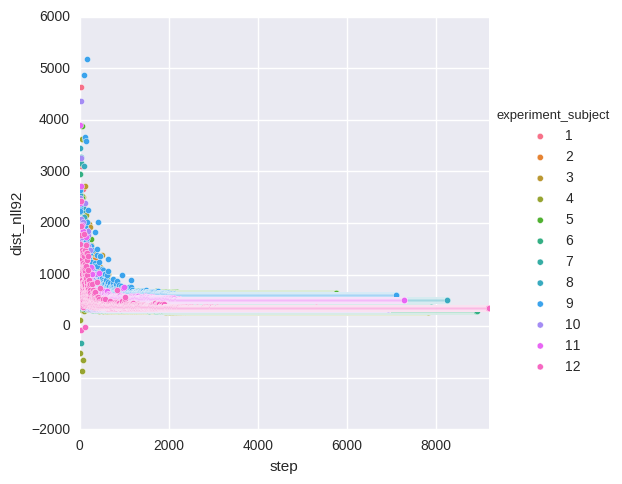

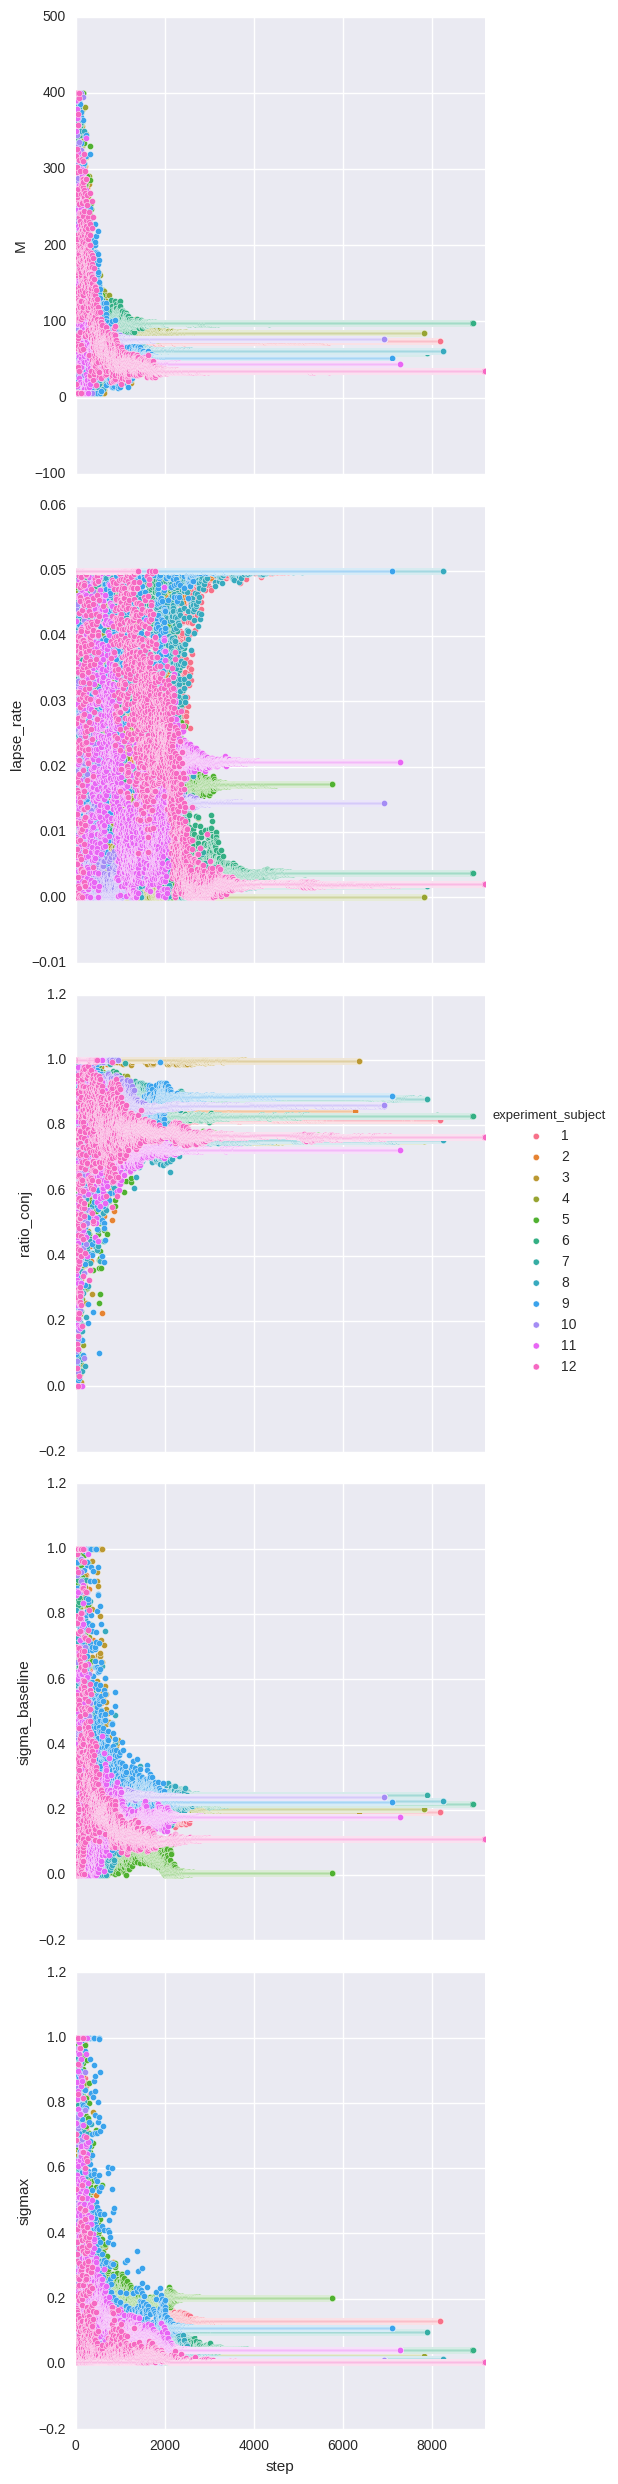

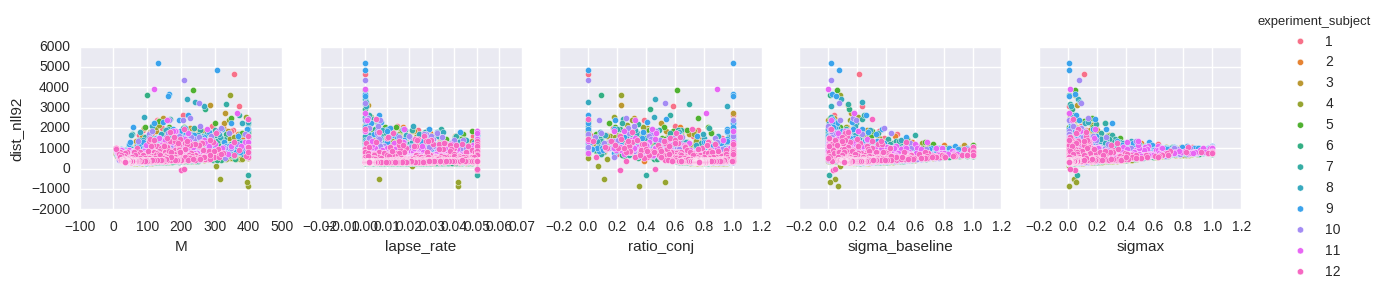

In [7]:
# Learning curve
g = sns.pairplot(df_best_fits,
                 y_vars=[metric],
                 x_vars=['step'],
                 hue='experiment_subject',
                 size=5,
                )

g.set(xlim=(-1, df_best_fits['step'].max())
)

# Check training of parameters
g = sns.pairplot(df_best_fits,
                 y_vars=parameter_names_sorted,
                 x_vars=['step'],
                 hue='experiment_subject',
                 size=5
                )
g.set(xlim=(-1, df_best_fits['step'].max()))

# Check parameters effects
sns.pairplot(df_best_fits,
             x_vars=parameter_names_sorted,
             y_vars=[metric],
             hue='experiment_subject',
            )


## Check parameters values obtained

In [8]:
df_bestparams_subjects = df_best_fits.groupby('experiment_subject').apply(
    lambda subDf: subDf.sort_values('step', ascending=False).head(10).median()
)
df_bestparams_subjects

,step,experiment_subject,dist_nll92,M,lapse_rate,ratio_conj,sigma_baseline,sigmax
experiment_subject,,,,,,,,
1,8184.5,1.0,507.637407,73.655636,5.000000e-02,0.817133,0.192443,0.130690
2,6264.5,2.0,543.351692,51.463880,5.000000e-02,0.843753,0.187548,0.109107
3,6354.5,3.0,377.229657,38.768283,9.818539e-16,0.996179,0.187255,0.005000
4,7824.5,4.0,278.866594,84.491634,1.485135e-15,0.750719,0.201796,0.025684
5,5754.5,5.0,644.137700,43.361340,1.728824e-02,0.768083,0.006310,0.203259
6,8904.5,6.0,299.460958,97.538912,3.706055e-03,0.828692,0.217964,0.044317
7,7884.5,7.0,489.476270,58.034593,1.765572e-03,0.880978,0.244362,0.099550
8,8244.5,8.0,508.796912,61.300953,5.000000e-02,0.754380,0.226802,0.015913
9,7104.5,9.0,613.188796,51.607175,5.000000e-02,0.888049,0.225338,0.110455


In [9]:
params_mean = df_bestparams_subjects.mean()
params_std = df_bestparams_subjects.std()

for param in parameter_names_sorted:
    print("%s   %.3g +- %.3g" % (param, params_mean[param], params_std[param]))

M   59.7 +- 19.6
lapse_rate   0.0217 +- 0.022
ratio_conj   0.823 +- 0.0773
sigma_baseline   0.185 +- 0.0665
sigmax   0.067 +- 0.0629


In [10]:
df_bestparams_subjects

,step,experiment_subject,dist_nll92,M,lapse_rate,ratio_conj,sigma_baseline,sigmax
experiment_subject,,,,,,,,
1,8184.5,1.0,507.637407,73.655636,5.000000e-02,0.817133,0.192443,0.130690
2,6264.5,2.0,543.351692,51.463880,5.000000e-02,0.843753,0.187548,0.109107
3,6354.5,3.0,377.229657,38.768283,9.818539e-16,0.996179,0.187255,0.005000
4,7824.5,4.0,278.866594,84.491634,1.485135e-15,0.750719,0.201796,0.025684
5,5754.5,5.0,644.137700,43.361340,1.728824e-02,0.768083,0.006310,0.203259
6,8904.5,6.0,299.460958,97.538912,3.706055e-03,0.828692,0.217964,0.044317
7,7884.5,7.0,489.476270,58.034593,1.765572e-03,0.880978,0.244362,0.099550
8,8244.5,8.0,508.796912,61.300953,5.000000e-02,0.754380,0.226802,0.015913
9,7104.5,9.0,613.188796,51.607175,5.000000e-02,0.888049,0.225338,0.110455


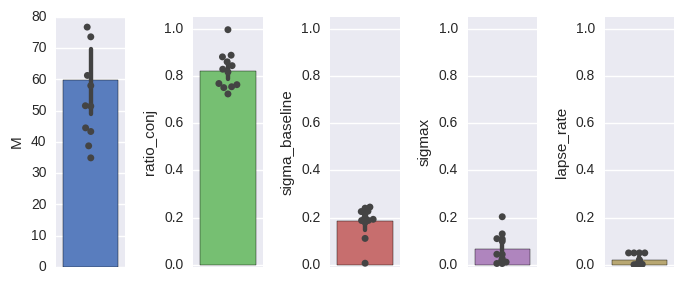

In [37]:
# df_best_params_meld = pd.melt(df_bestparams_subjects, id_vars=['experiment_subject', 'step', 'dist_nll'])
parameter_names_sorted = ['M', 'ratio_conj', 'sigma_baseline', 'sigmax', 'lapse_rate']
colors = sns.color_palette('muted', n_colors=5)
fig_parameters, axes = plt.subplots(1, 5, figsize=(7, 3))
axes = axes.flatten()
for i, param in enumerate(parameter_names_sorted):
    sns.barplot(df_bestparams_subjects[param], orient='v', ax=axes[i], color=colors[i])
    sns.swarmplot(df_bestparams_subjects[param], orient='v', ax=axes[i], color='#444444')

axes[0].set_ylim((-0.02, 80))
for ax in axes[1:]:
    ax.set_ylim((-0.01, 1.05))
fig_parameters.set_tight_layout(True)


## Get plots for all subjects, and associated EM fits

In [12]:
experiment_parameters = dict(action_to_do='launcher_do_fitexperiment_subject_allmetrics',
                             inference_method='sample',
                             experiment_id='bays09',
                             selection_method='last',
                             renormalize_sigma=None,
                             sigmay=0.00001,
                             num_samples=100,
                             code_type='mixed',
                             slice_width=0.07,
                             burn_samples=100,
                             ratio_conj=0.7,
                             stimuli_generation_recall='random',
                             autoset_parameters=None,
                             )

all_results = dict()
all_plots_fit_exp = dict()

for subject in progress.ProgressDisplay(subject_space):
    print "FitExperimentAllTSubject for subject %d" % subject

    experiment_parameters.update(df_bestparams_subjects.loc[subject])
    for key in ['M', 'experiment_subject']:
        experiment_parameters[key] = int(experiment_parameters[key])
    
    with io.capture_output() as captured:
        experiment_launcher = ExperimentLauncher(run=True, arguments_dict=experiment_parameters)
        fit_exp = experiment_launcher.all_vars['fit_exp']
        all_results[subject] = experiment_launcher.all_vars['all_outputs_data']
        all_plots_fit_exp[subject] = PlotsFitExperimentAllTPaperTheo(fit_exp)
        

[0%] --
FitExperimentAllTSubject for subject 1
[8%] 9m40s
FitExperimentAllTSubject for subject 2
[16%] 8m31s
FitExperimentAllTSubject for subject 3
[25%] 7m22s
FitExperimentAllTSubject for subject 4
[33%] 6m34s
FitExperimentAllTSubject for subject 5
[41%] 5m51s
FitExperimentAllTSubject for subject 6
[50%] 5m6s
FitExperimentAllTSubject for subject 7
[58%] 4m20s
FitExperimentAllTSubject for subject 8
[66%] 3m31s
FitExperimentAllTSubject for subject 9
[75%] 2m36s
FitExperimentAllTSubject for subject 10
[83%] 1m42s
FitExperimentAllTSubject for subject 11
[91%] 51s
FitExperimentAllTSubject for subject 12
[100%] 9m50s


[0%] --
Subject 1
[8%] 7s
Subject 2
[16%] 6s
Subject 3
[25%] 6s
Subject 4
[33%] 5s
Subject 5
[41%] 5s
Subject 6
[50%] 4s
Subject 7
[58%] 4s
Subject 8
[66%] 3s
Subject 9
[75%] 2s
Subject 10
[83%] 1s
Subject 11
[91%] 1s
Subject 12
[100%] 8s


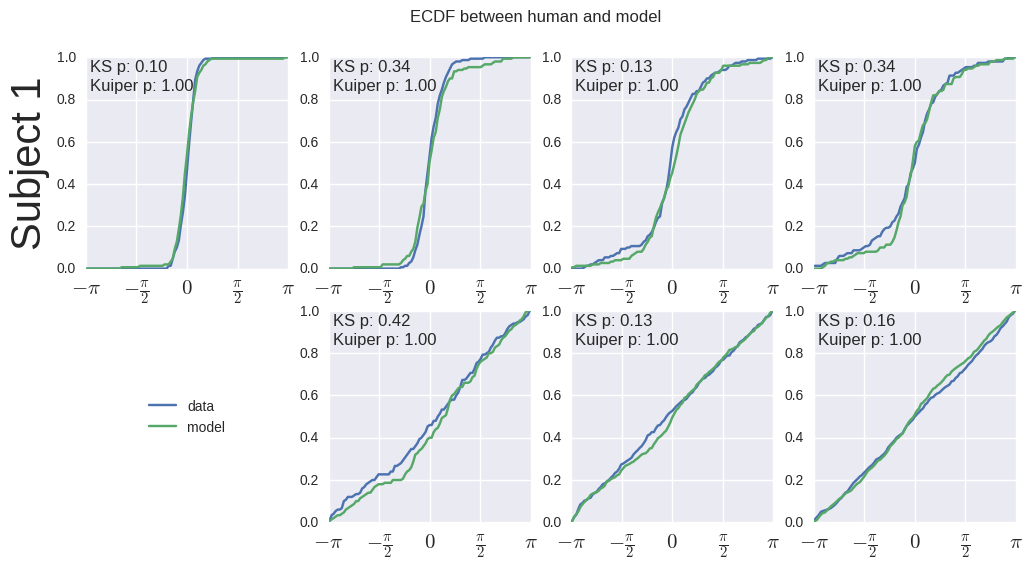

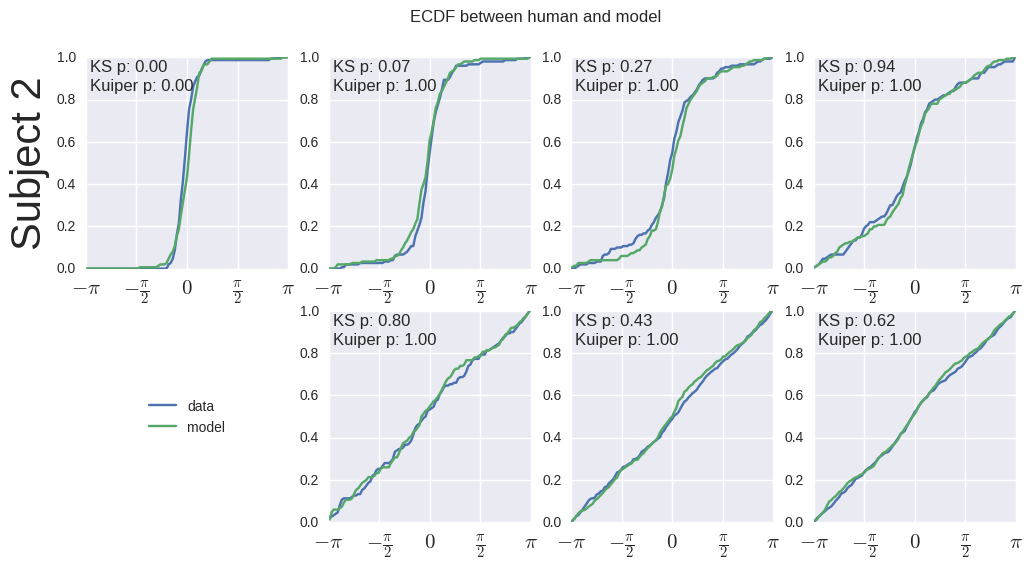

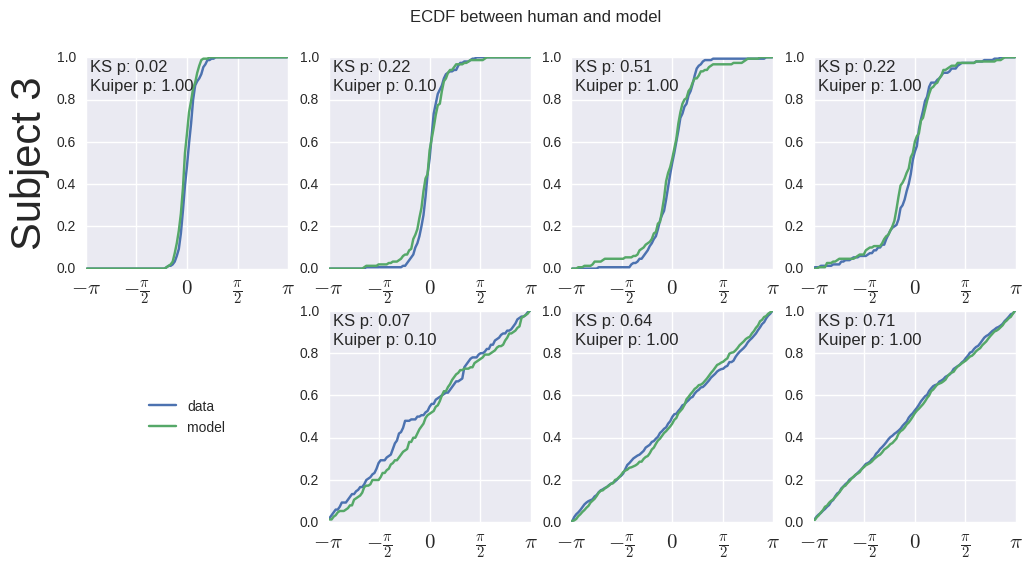

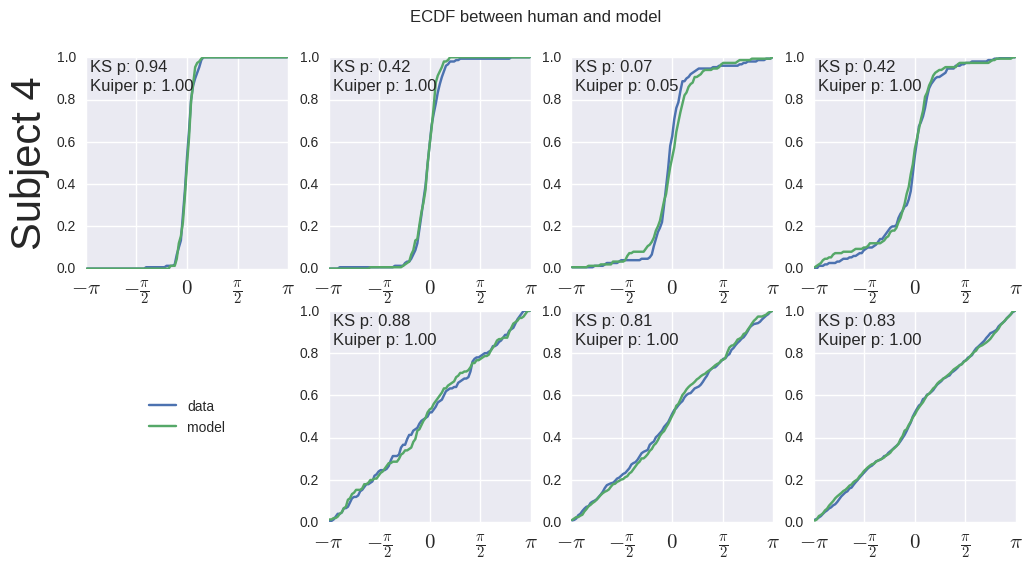

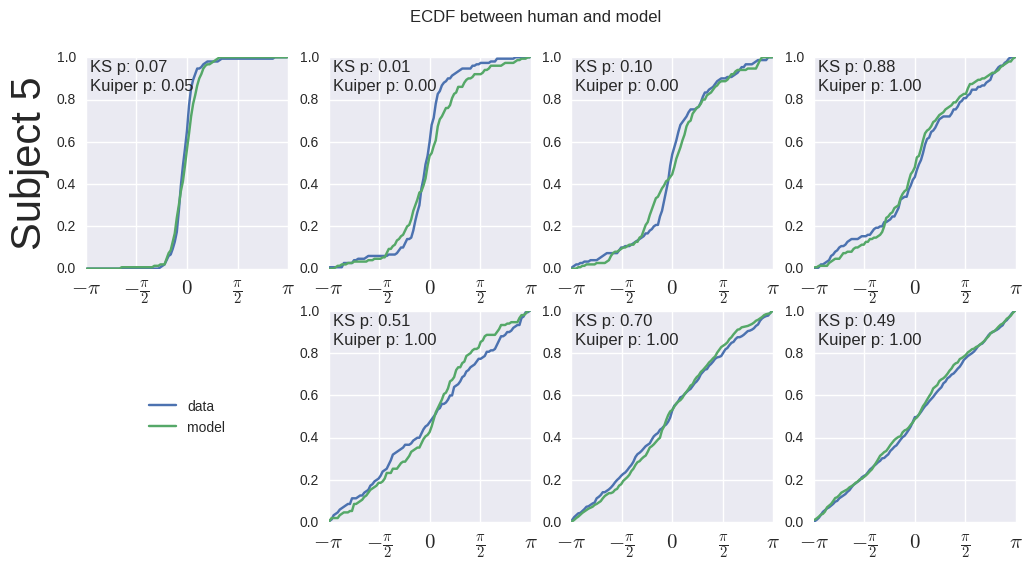

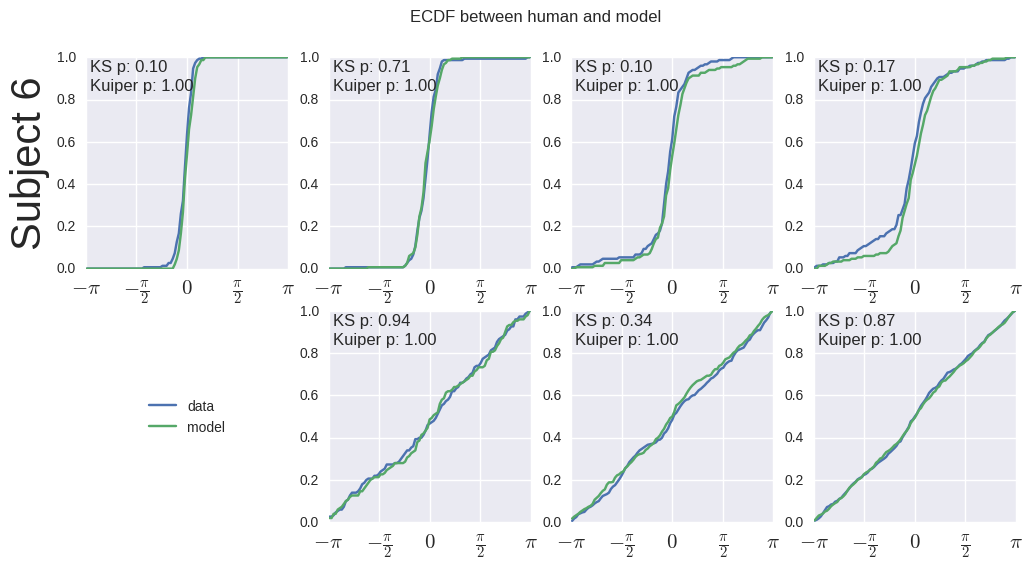

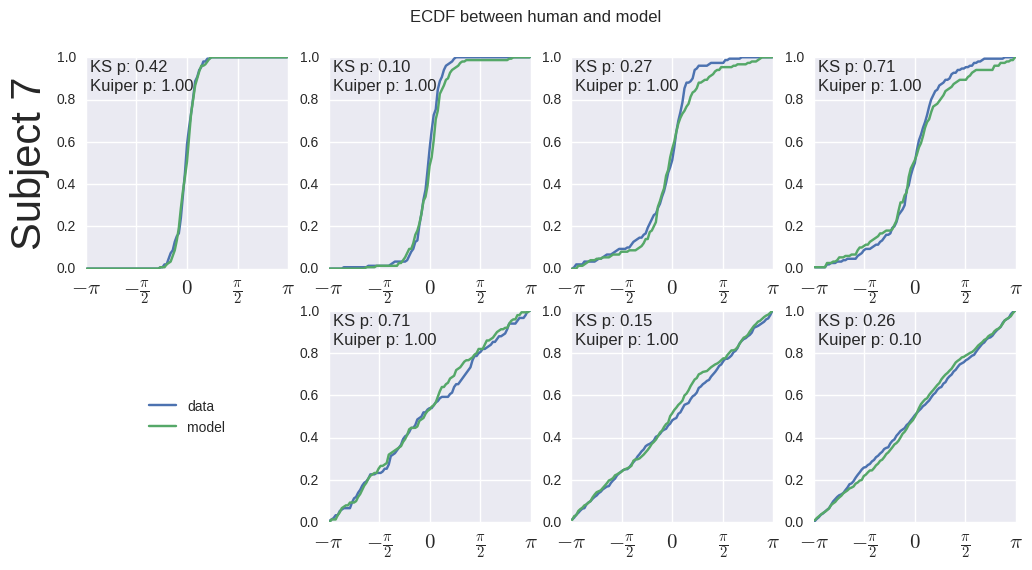

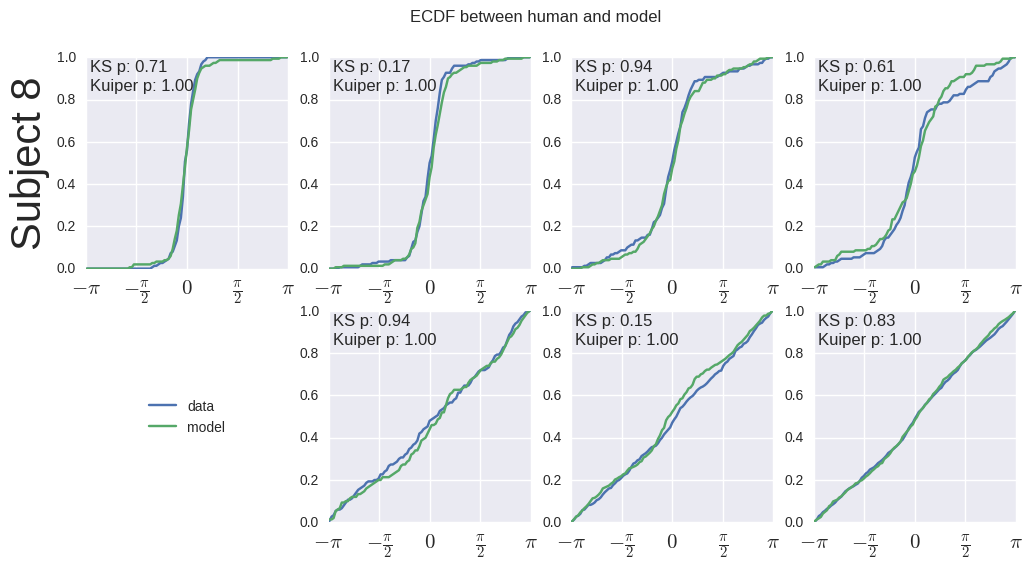

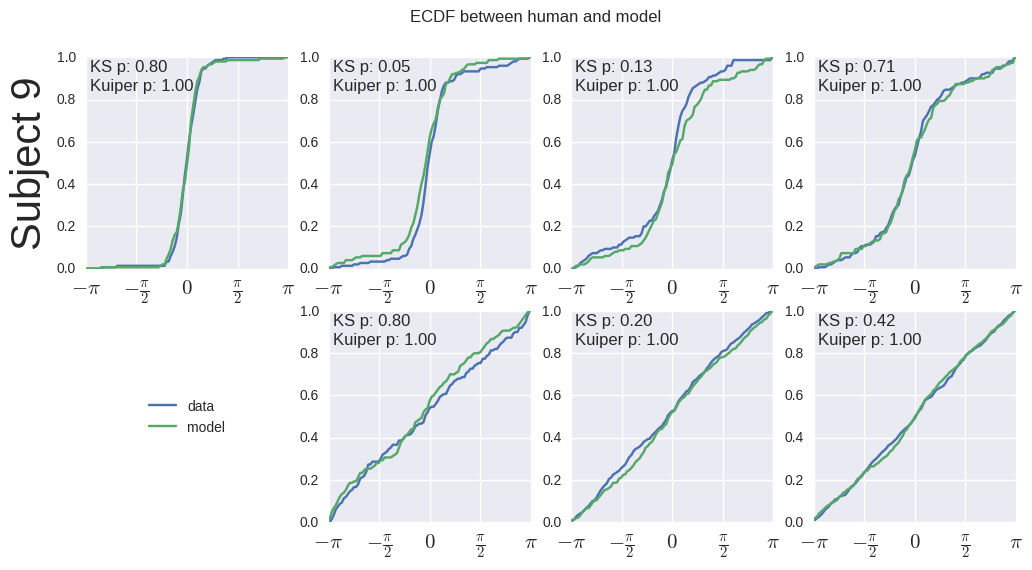

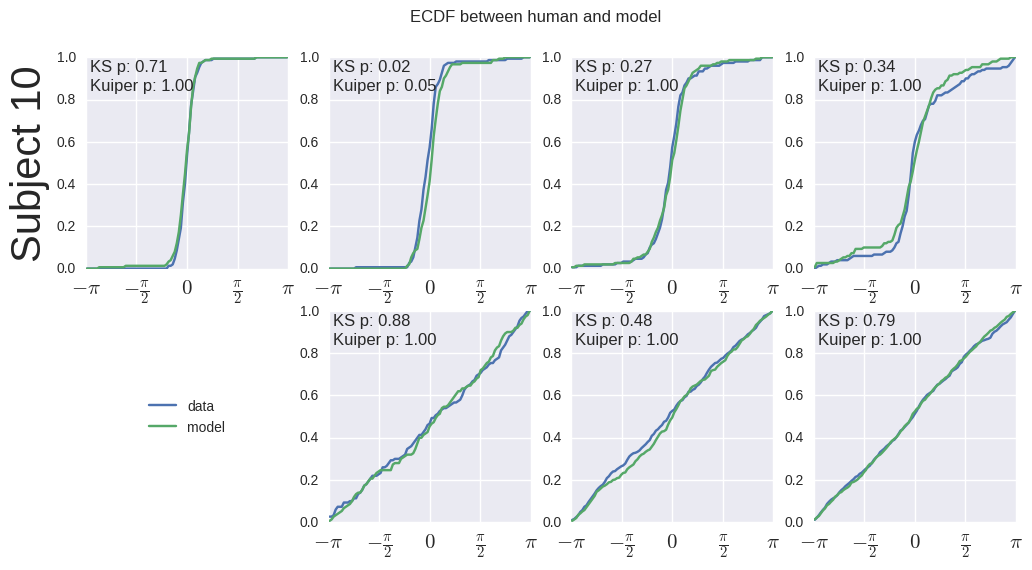

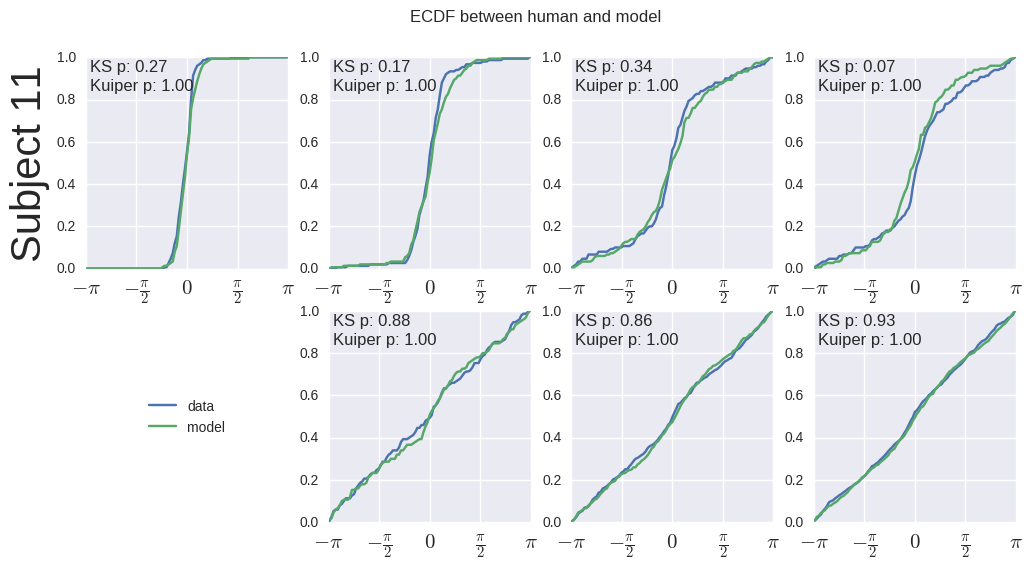

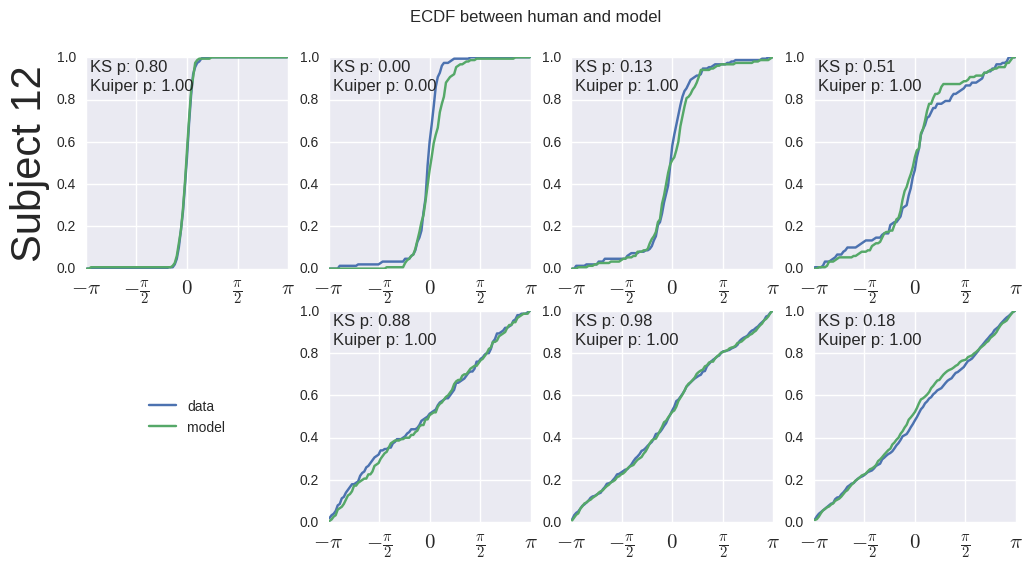

In [13]:
all_histogram_results = dict()

for subject in progress.ProgressDisplay(subject_space):
    print "Subject %d" % subject
    with io.capture_output(display=False, stderr=False) as captured:
        axes, all_histogram_results[subject] = all_plots_fit_exp[subject].plots_KS_comparison_fig2fig5(bins=100)
        axes[0, 0].set_ylabel('Subject %d' % subject, fontsize=30)


In [14]:
T_space = np.sort(all_histogram_results[subject]['kuiper_pval'].keys())

str_out = ""
for subject in progress.ProgressDisplay(subject_space):
    count_significant = 0
    str_out = str_out + "S:%3d | " % subject
    for condition in ['targets', 'nontargets']:
        for T, data in all_histogram_results[subject]['kuiper_pval'].iteritems():
            if condition in data:
                str_out = str_out + "%.3f " % data[condition]
                if data[condition] > 0.05:
                    count_significant += 1
        
        str_out = str_out + " | "
    
    str_out = str_out + " => %d good" % count_significant
    str_out = str_out + '\n'
print str_out

[0%] --
[8%] 0s
[16%] 0s
[25%] 0s
[33%] 0s
[41%] 0s
[50%] 0s
[58%] 0s
[66%] 0s
[75%] 0s
[83%] 0s
[91%] 0s
[100%] 0s
S:  1 | 1.000 1.000 1.000 1.000  | 1.000 1.000 1.000  |  => 7 good
S:  2 | 0.001 1.000 1.000 1.000  | 1.000 1.000 1.000  |  => 6 good
S:  3 | 1.000 0.100 1.000 1.000  | 0.100 1.000 1.000  |  => 7 good
S:  4 | 1.000 1.000 0.050 1.000  | 1.000 1.000 1.000  |  => 6 good
S:  5 | 0.050 0.002 0.002 1.000  | 1.000 1.000 1.000  |  => 4 good
S:  6 | 1.000 1.000 1.000 1.000  | 1.000 1.000 1.000  |  => 7 good
S:  7 | 1.000 1.000 1.000 1.000  | 1.000 1.000 0.100  |  => 7 good
S:  8 | 1.000 1.000 1.000 1.000  | 1.000 1.000 1.000  |  => 7 good
S:  9 | 1.000 1.000 1.000 1.000  | 1.000 1.000 1.000  |  => 7 good
S: 10 | 1.000 0.050 1.000 1.000  | 1.000 1.000 1.000  |  => 6 good
S: 11 | 1.000 1.000 1.000 1.000  | 1.000 1.000 1.000  |  => 7 good
S: 12 | 1.000 0.002 1.000 1.000  | 1.000 1.000 1.000  |  => 6 good



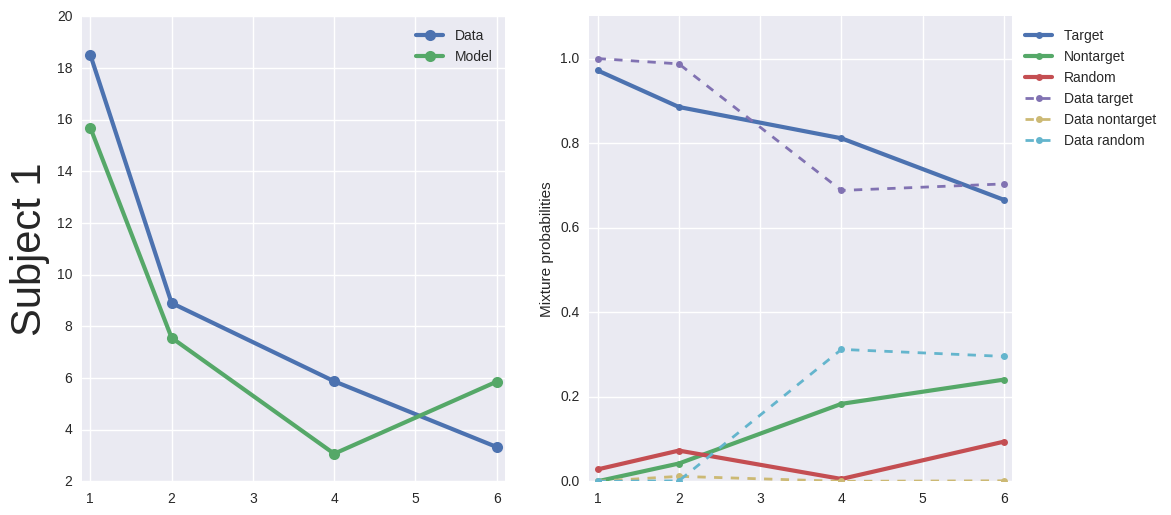

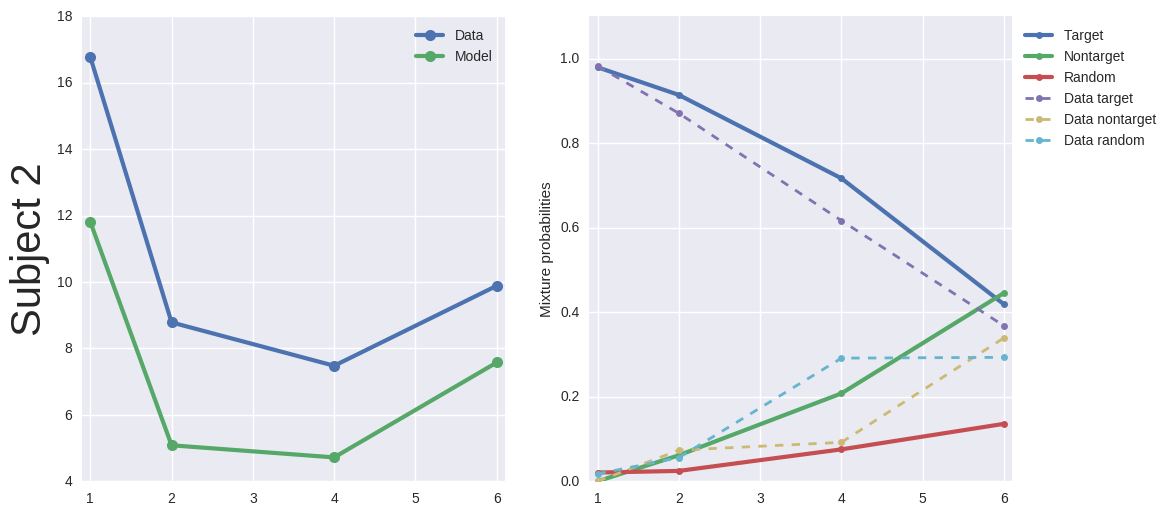

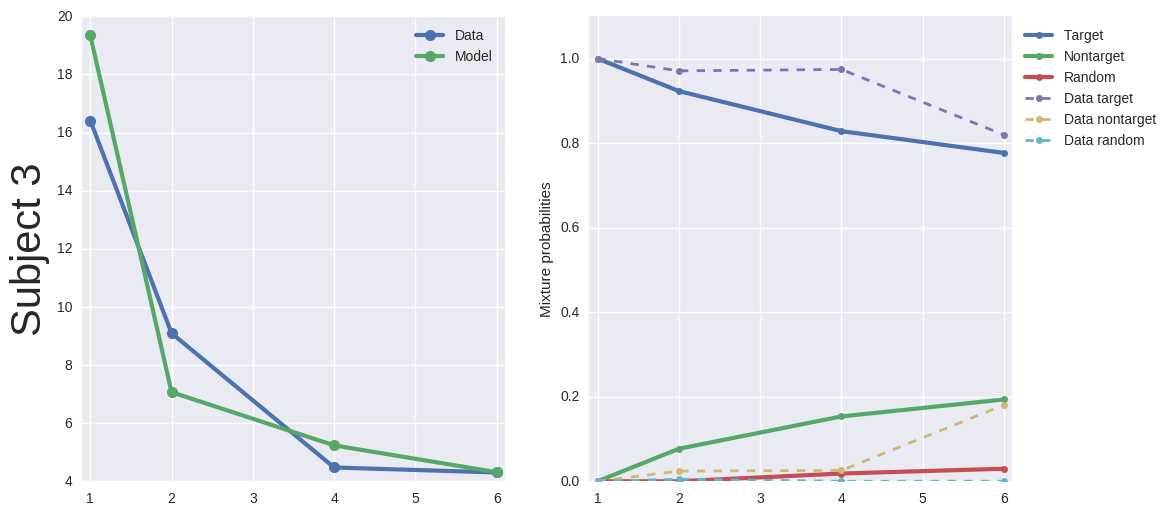

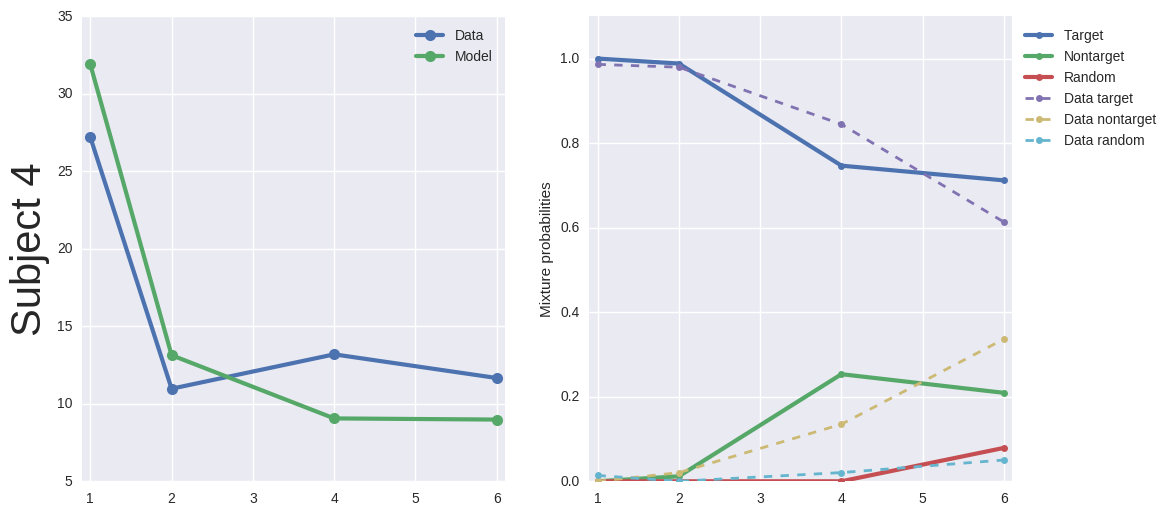

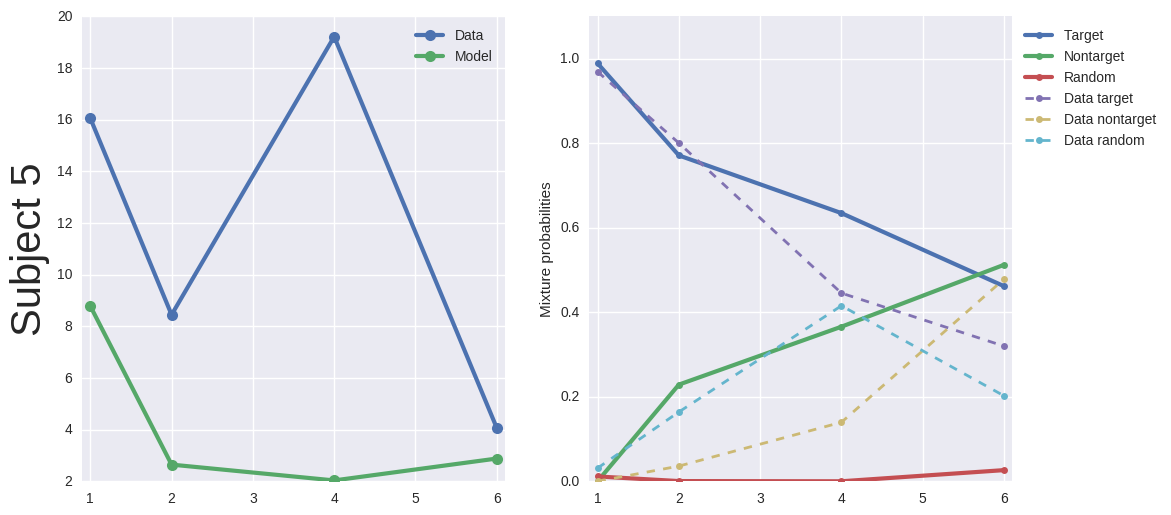

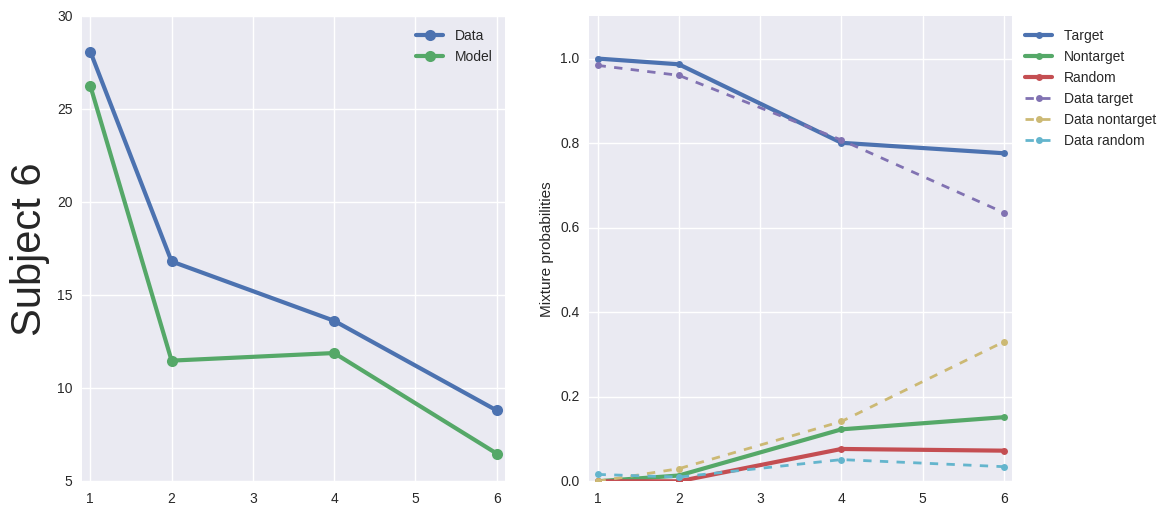

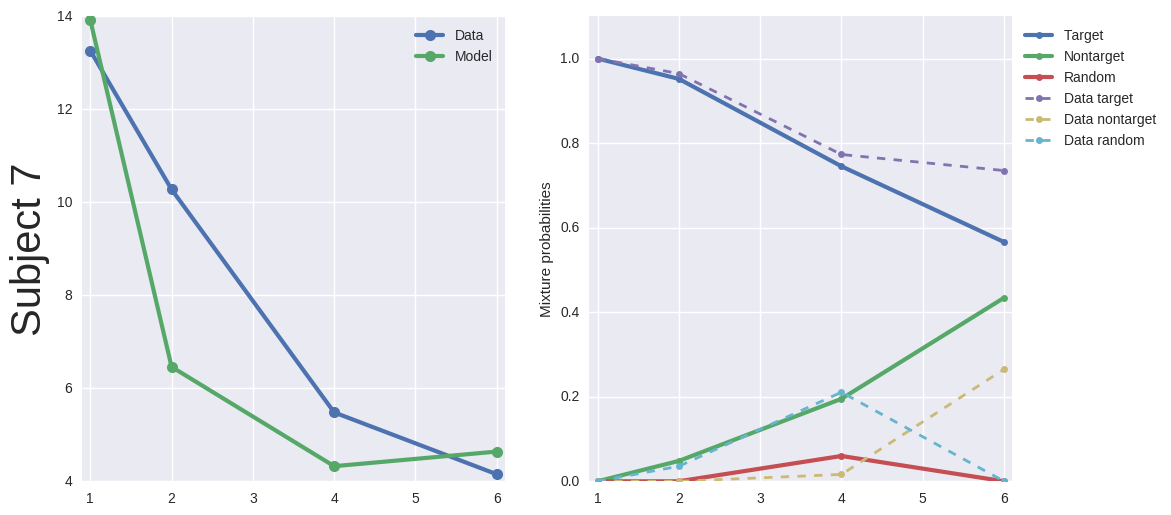

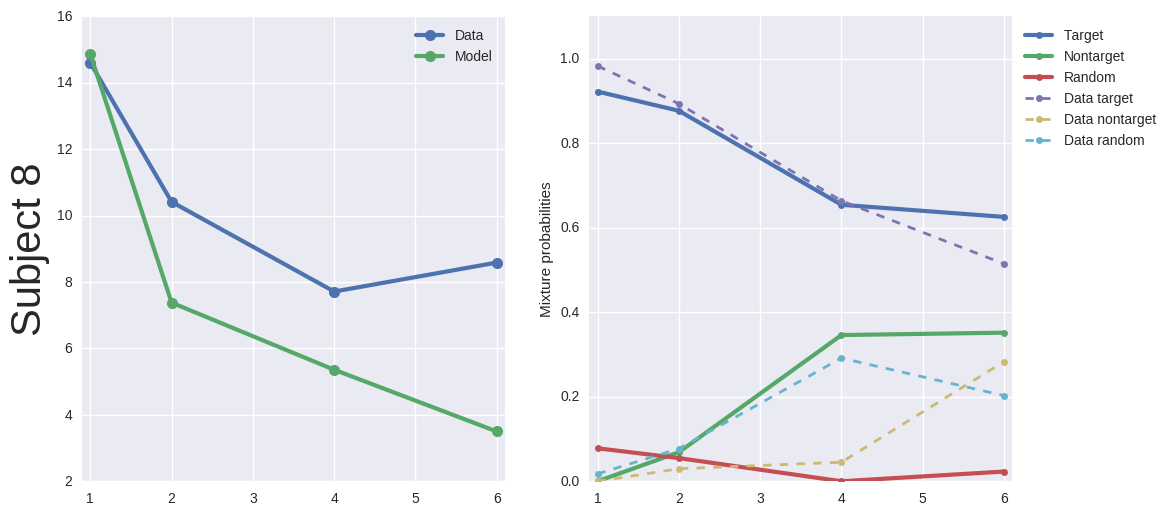

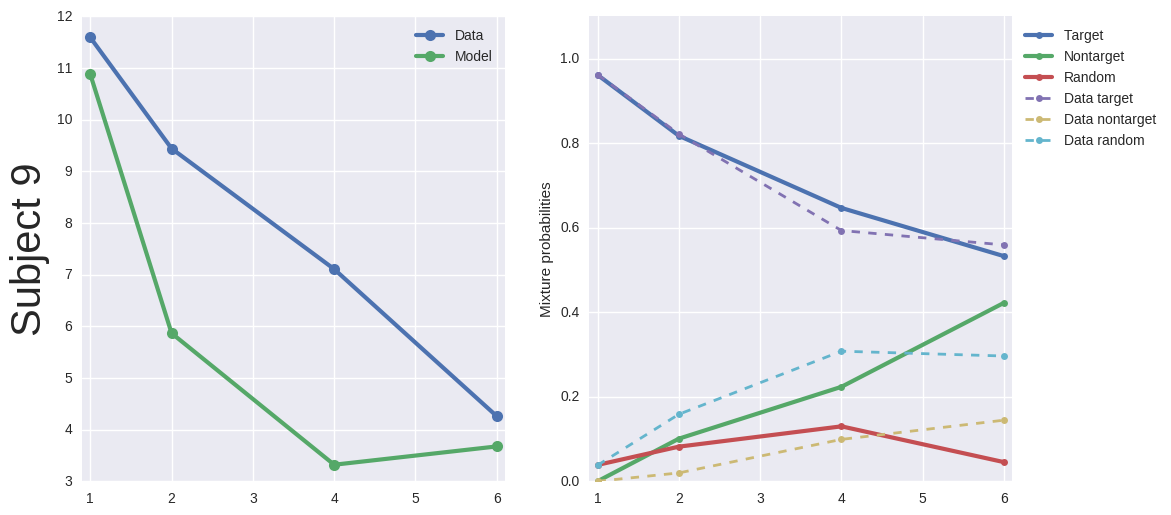

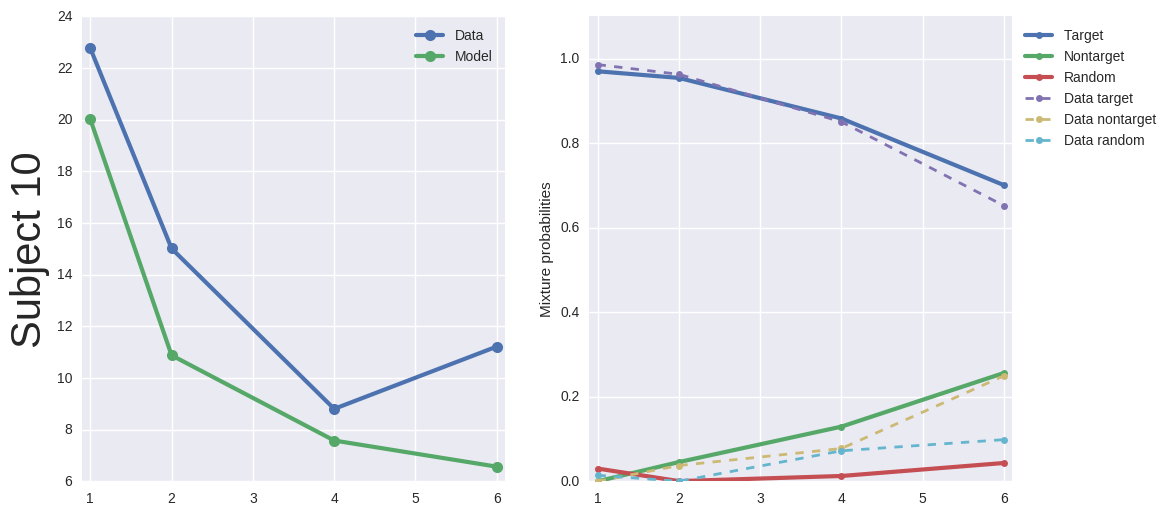

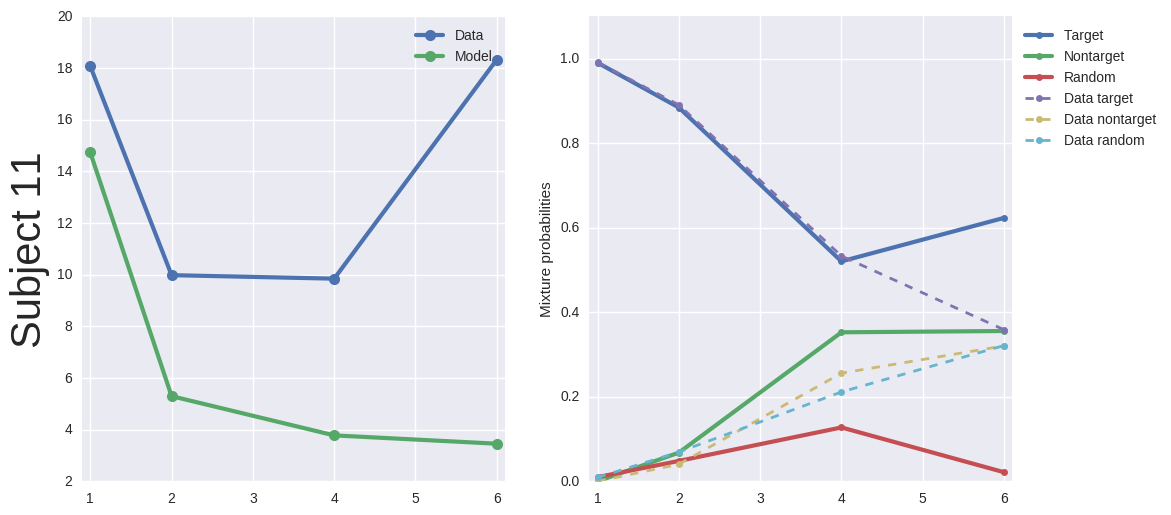

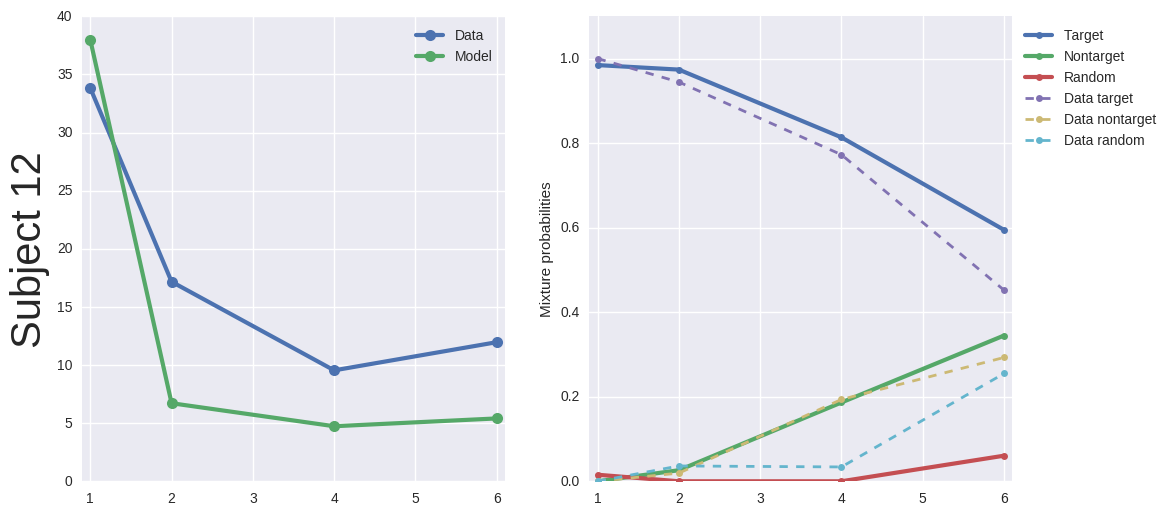

In [15]:
subj_fits_axes = dict()
with io.capture_output(display=False) as captured:
    for subject in subject_space:
        subj_fits_axes[subject] = all_plots_fit_exp[subject].plots_memmixtcurves_fig6fig13(num_repetitions=1, 
                                                                        use_cache=True, 
                                                                        layout='horizontal')
        subj_fits_axes[subject][0].set_ylabel('Subject %d' % subject, fontsize=30)
        subj_fits_axes[subject][0].set_title('')
        subj_fits_axes[subject][1].set_title('')
        subj_fits_axes[subject][0].set_xlabel('')
        subj_fits_axes[subject][1].set_xlabel('')

## Checking if average of parameters gives a good fit to the overall dataset

In [16]:
# Compute average parameter
df_avgparams_subjects = df_bestparams_subjects.median()
df_avgparams_subjects

step                  7554.500000
experiment_subject       6.500000
dist_nll92             498.556839
M                       54.820884
lapse_rate               0.015896
ratio_conj               0.822913
sigma_baseline           0.197120
sigmax                   0.044010
dtype: float64

In [24]:
experiment_parameters = dict(action_to_do='launcher_do_fitexperiment_allmetrics',
                             inference_method='none',
                             experiment_id='bays09',
                             selection_method='last',
                             renormalize_sigma=None,
                             sigmay=0.00001,
                             num_samples=100,
                             code_type='mixed',
                             slice_width=0.07,
                             burn_samples=100,
                             ratio_conj=0.7,
                             stimuli_generation_recall='random',
                             autoset_parameters=None,
                             )

experiment_parameters.update(df_avgparams_subjects)
for key in ['M', 'experiment_subject']:
    experiment_parameters[key] = int(experiment_parameters[key])
    
with io.capture_output(display=False, stderr=True) as captured:
    experiment_launcher = ExperimentLauncher(run=True, arguments_dict=experiment_parameters)
    avgparam_fit_exp = experiment_launcher.all_vars['fit_exp']
    avgparam_results = experiment_launcher.all_vars['all_outputs_data']
    avgparam_plots_fit_exp = PlotsFitExperimentAllTPaperTheo(avgparam_fit_exp)


In [25]:
# with io.capture_output(display=False) as captured:
#     _ = avgparam_plots_fit_exp.plots_KS_comparison_fig2fig5(bins=100)

In [26]:
# with io.capture_output(display=False) as captured:
#     _ = avgparam_plots_fit_exp.plots_memmixtcurves_fig6fig13(num_repetitions=5, use_cache=True)

## Checking averaging the Subjects EM Fits

In [28]:
subjects_em_fits_list = []
for subject in subject_space:
    for T_i, T in enumerate(T_space):
        em_fits_subject = all_results[subject]['result_em_fits'].squeeze()
        subjects_em_fits_list.append(
            dict(subject=subject,
                 T=T,
                 em_kappa=em_fits_subject[T_i, 0],
                 em_target=em_fits_subject[T_i, 1],
                 em_nontarget=em_fits_subject[T_i, 2],
                 em_random=em_fits_subject[T_i, 3],
                 em_ll=em_fits_subject[T_i, 4],
                 em_bic=em_fits_subject[T_i, 5],
                 model_bic=all_results[subject]['result_bic'].squeeze()[T_i],
                 model_ll=all_results[subject]['result_ll_sum'].squeeze()[T_i]
                )
            )

subjects_em_fits_df = pd.DataFrame(subjects_em_fits_list)
subjects_em_fits_df

,T,em_bic,em_kappa,em_ll,em_nontarget,em_random,em_target,model_bic,model_ll,subject
0,1,79.680679,15.690031,-29.819069,0.000000,2.807197e-02,0.971928,120.505413,-50.231436,1
1,2,253.009905,7.555849,-116.483682,0.042007,7.260791e-02,0.885385,279.163655,-129.560557,1
2,4,398.399974,3.065765,-189.178717,0.183188,5.446959e-03,0.811365,501.122229,-240.539844,1
3,6,394.578842,5.858180,-187.268150,0.240525,9.381327e-02,0.665662,548.837371,-264.397415,1
4,1,113.788394,11.810531,-46.872926,0.000000,2.061824e-02,0.979382,226.999614,-103.478536,2
5,2,280.444488,5.082988,-130.200974,0.061526,2.452935e-02,0.913944,371.081378,-175.519419,2
6,4,386.787526,4.719270,-183.372493,0.207916,7.548333e-02,0.716600,532.753313,-256.355386,2
7,6,461.631437,7.577398,-220.794448,0.445600,1.359059e-01,0.418494,570.450289,-275.203874,2
8,1,7.274386,19.342935,6.384078,0.000000,9.050824e-09,1.000000,208.186600,-94.072029,3
9,2,216.511281,7.066180,-98.234370,0.076941,1.904730e-07,0.923059,352.950159,-166.453809,3


In [18]:
# This computes the average fits across subjects. Exactly same as Fig 6!
subjects_pivot = subjects_em_fits_df[['em_kappa', 'em_target', 'em_nontarget', 'em_random', 'T']].groupby('T')

subjectsavg_emfit = dict(
    mean=subjects_pivot.mean().as_matrix(),
    std=subjects_pivot.std().as_matrix()
)

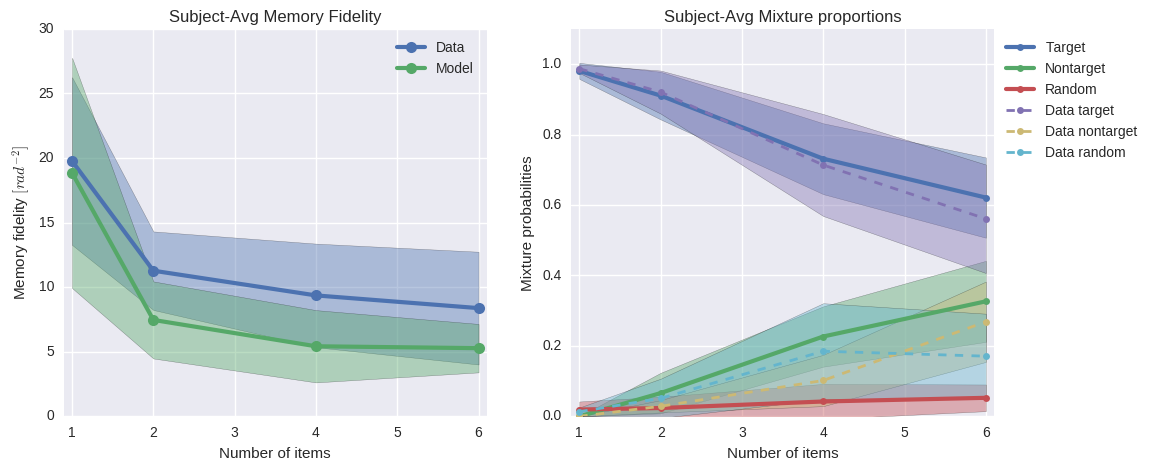

In [35]:
_, subj_avgfit = plt.subplots(1, 2, figsize=(12, 5))
avgparam_plots_fit_exp._PlotsFitExperimentAllTPaperTheo__plot_memcurves(subjectsavg_emfit, suptitle_text="Subject-Avg Memory Fidelity", ax=subj_avgfit[0])
avgparam_plots_fit_exp._PlotsFitExperimentAllTPaperTheo__plot_mixtcurves(subjectsavg_emfit, suptitle_text="Subject-Avg Mixture proportions", ax=subj_avgfit[1])

# Fits look even better than median?



In [30]:
# Store figures
dataio = DataIO(output_folder=os.path.join(os.path.abspath("."), "outputs"), 
                label='thesis_subject_bays09_ll92', calling_function='')
dataio.make_link_output_to_dropbox(dropbox_current_experiment_folder='fitexperiment_subject_cmaes_08_2016')

=== FileIO ready: /nfs/data3/lmatthey/visual_working_mem/fitexperiment_subject_cmaes_08_2016/3try/outputs/thesis_subject_bays09_ll92-a53cbded-f30a-4601-be2e-16d25b5a9c9c ===
Doing dropbox symlink:  /nfs/data3/lmatthey/visual_working_mem/fitexperiment_subject_cmaes_08_2016/3try/outputs /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/git-bayesian-visual-working-memory/Experiments/fitexperiment_subject_cmaes_08_2016/fitexperiment_subject_cmaes_08_2016_3try
Symlink failed:  /nfs/data3/lmatthey/visual_working_mem/fitexperiment_subject_cmaes_08_2016/3try/outputs /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/git-bayesian-visual-working-memory/Experiments/fitexperiment_subject_cmaes_08_2016/fitexperiment_subject_cmaes_08_2016_3try


In [36]:
# Subject-Avg fits
subj_avgfit[0].figure.savefig(dataio.create_formatted_filename("subjectavg_{label}_{unique_id}.pdf"))

In [33]:
# Subjects fits
for subj, sub_axes in subj_fits_axes.iteritems():
    sub_axes[0].figure.savefig(dataio.create_formatted_filename("subject_%d_emfits_{label}_{unique_id}.pdf" % subj))

In [34]:
# Parameters
fig_parameters.savefig(dataio.create_formatted_filename("barplot_params_{label}_{unique_id}.pdf"))